In [1]:
#SQLite Db
import sqlite3
#dataframes
import pandas as pd

import numpy as np
#plots
import matplotlib.pyplot as plt
#lsq interpolation
import scipy.interpolate as si 

In [3]:
# Create the connection.
cnx = sqlite3.connect('data.db')

#Find the name of the table
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

turbine


In [4]:
#read sql
df = pd.read_sql_query("SELECT * FROM turbine", cnx)

In [5]:
#Split started column to two columns
df[['Date','Time']] = df.valuetime.str.split(" ",expand=True,)
df = df[['started','Date', 'Time', 'locname', 'plantno', 'power','wind']]

In [6]:
#change time format
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M:%S')
df

,started,Date,Time,locname,plantno,power,wind
0,2021-06-04 10:35:53.793993,2021-06-04,10:35:51,Ballincurry,1,698.0,8.700000
1,2021-06-04 10:35:53.793993,2021-06-04,10:35:52,Ballincurry,2,612.0,6.800000
2,2021-06-04 10:35:53.793993,2021-06-04,10:35:54,Ballincurry,1,704.0,8.300000
3,2021-06-04 10:35:53.793993,2021-06-04,10:35:55,Ballincurry,2,583.0,6.400000
4,2021-06-04 10:35:53.793993,2021-06-04,10:35:57,Ballincurry,1,716.0,8.500000
...,...,...,...,...,...,...,...
126220,2021-06-21 16:34:38.742056,2021-06-21,17:23:16,Ballincurry,1,1100.0,7.700000
126221,2021-06-21 16:34:38.742056,2021-06-21,17:23:17,Ballincurry,2,936.0,7.800000
126222,2021-06-21 16:34:38.742056,2021-06-21,17:23:19,Ballincurry,1,1065.0,8.300000
126223,2021-06-21 16:34:38.742056,2021-06-21,17:23:21,Ballincurry,2,958.0,8.400001


In [8]:
#create a df with hours 
df1=pd.date_range("00:00:00", "23:00:00", freq="60min").strftime('%H:%M:%S')

#another times
#df2=pd.date_range("00:00:02", "23:00:02", freq="60min").strftime('%H:%M:%S')
#df3=pd.date_range("00:00:59", "23:00:59", freq="60min").strftime('%H:%M:%S')
#df_time=df1.append(df2)
#df_time=df_time.append(df3)

print(df1)

Index(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00',
       '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00',
       '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00'],
      dtype='object')


In [49]:
#keep only row with time format tt:00:00
#df_hourly=pd.DataFrame()
#for a in df1:
    #df_hourly = df_hourly.append(df.loc[df['Time'] == a])
#df_hourly.head(n=5)
df_hourly=df

#print df
df_hourly.head(10)

,started,Date,Time,locname,plantno,power,wind,DateTime
0,2021-06-04 10:35:53.793993,2021-06-04,10:35:51,Ballincurry,1,698.0,8.7,2021-06-04 10:35:51
1,2021-06-04 10:35:53.793993,2021-06-04,10:35:52,Ballincurry,2,612.0,6.8,2021-06-04 10:35:52
2,2021-06-04 10:35:53.793993,2021-06-04,10:35:54,Ballincurry,1,704.0,8.3,2021-06-04 10:35:54
3,2021-06-04 10:35:53.793993,2021-06-04,10:35:55,Ballincurry,2,583.0,6.4,2021-06-04 10:35:55
4,2021-06-04 10:35:53.793993,2021-06-04,10:35:57,Ballincurry,1,716.0,8.5,2021-06-04 10:35:57
5,2021-06-04 10:35:53.793993,2021-06-04,10:35:59,Ballincurry,2,553.0,7.3,2021-06-04 10:35:59
6,2021-06-04 10:35:53.793993,2021-06-04,10:36:00,Ballincurry,1,748.0,9.0,2021-06-04 10:36:00
7,2021-06-04 10:35:53.793993,2021-06-04,10:36:02,Ballincurry,2,529.0,6.9,2021-06-04 10:36:02
8,2021-06-04 10:35:53.793993,2021-06-04,10:36:04,Ballincurry,1,778.0,9.3,2021-06-04 10:36:04
9,2021-06-04 10:35:53.793993,2021-06-04,10:36:05,Ballincurry,2,528.0,7.1,2021-06-04 10:36:05


In [50]:
#separe date time columns
df_hourly["DateTime"] = df_hourly["Date"] + " " + df_hourly["Time"]

#order ascending by wind to apply interpolation
df_hourly=df_hourly.sort_values(by=['wind'], axis=0, ascending=True)

#positive values for power
df_hourly=df_hourly[(df_hourly.power >= 0.0)]

#print first 15 rows
df_hourly.head(n=15)


,started,Date,Time,locname,plantno,power,wind,DateTime
85149,2021-06-09 12:53:55.145600,2021-06-11,10:23:16,Ballincurry,1,0.0,0.0,2021-06-11 10:23:16
94875,2021-06-09 12:53:55.145600,2021-06-11,15:00:47,Ballincurry,1,0.0,0.9,2021-06-11 15:00:47
23147,2021-06-06 08:34:51.722051,2021-06-06,14:34:38,Ballincurry,1,4.0,1.3,2021-06-06 14:34:38
23145,2021-06-06 08:34:51.722051,2021-06-06,14:34:35,Ballincurry,1,0.0,1.3,2021-06-06 14:34:35
111081,2021-06-16 10:52:29.278947,2021-06-16,16:10:57,Ballincurry,1,28.0,1.3,2021-06-16 16:10:57
112025,2021-06-16 10:52:29.278947,2021-06-16,16:36:16,Ballincurry,1,11.0,1.3,2021-06-16 16:36:16
119133,2021-06-16 10:52:29.278947,2021-06-17,11:24:49,Ballincurry,2,29.0,1.4,2021-06-17 11:24:49
10755,2021-06-06 08:34:51.722051,2021-06-06,09:13:17,Ballincurry,2,3.0,1.4,2021-06-06 09:13:17
23372,2021-06-06 08:34:51.722051,2021-06-06,14:40:30,Ballincurry,2,24.0,1.4,2021-06-06 14:40:30
111079,2021-06-16 10:52:29.278947,2021-06-16,16:10:54,Ballincurry,1,32.0,1.4,2021-06-16 16:10:54


In [54]:
#separe by plant no
df_hourly_1=df_hourly[(df_hourly.plantno == 1)]
df_hourly_2=df_hourly[(df_hourly.plantno == 2)]

#sort ascending
#df_hourly_2=df_hourly_2.sort_values(by=['power'])

#df_hourly_2=df_hourly_2[2:]

#choose one of the turbine
df_hourly=df_hourly_1

#sort again
df_hourly=df_hourly.sort_values(by=['wind'])

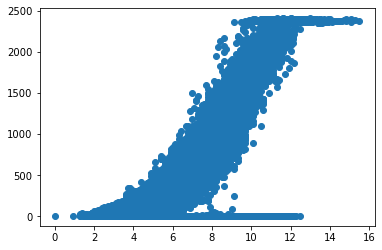

In [55]:
plt.plot(df_hourly["wind"], df_hourly["power"],"o")
plt.show()

## LSQ Spline

source: http://vadym-pasko.com/blog/2015/03/06/spline-approx-scipy.html

In [56]:
x=df_hourly["wind"].reset_index(drop=True)
\
y=df_hourly["power"].reset_index(drop=True)
wmin, wmax = min(x), max(x) 
pmin, pmax = min(y), max(y)

In [57]:
#Define some control points and set some variables:
n = len(x)
plotpoints = 100

#set spline degree and find knot vector:
k = 2

#Construct uniform knot vector:
knotspace = range(n)
knots = si.InterpolatedUnivariateSpline(knotspace, knotspace, k=k).get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))

#nknot - is the number of knots in the reduced knot vector (one without k repeating values at the endings).
nknot=5
knot_offset = (wmax - wmin)/(nknot + 1)
knots = np.linspace(knot_offset, wmax-knot_offset, nknot)

#define the vector of weights w in order to force our further approximations to pass close to the end points of the original data
wend = 3
num_points=len(x)
w = [wend] + [1]*(num_points-2) + [wend]

In [58]:
#Instantiate LSQUnivariateSpline class using coordinates of the data points, the knot vector and the weight vector:
lsqspline = si.LSQUnivariateSpline(x, y, knots, k=k, w=w)

In [59]:
# evaluate control points 
def getControlPoints(knots, k):
    n = len(knots) - 1 - k
    cx = np.zeros(n)
    for i in range(n):
        tsum = 0
        for j in range(1, k+1):
            tsum += knots[i+j]
        cx[i] = float(tsum)/k
    return cx

cp = getControlPoints(knots_full, k)

In [60]:
#Get full-length knot vector, spline coefficients and coordinates of control points along the x-axis:
knots = lsqspline.get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))
coeffs_p = lsqspline.get_coeffs()
coeffs_w = getControlPoints(knots_full, k)

In [61]:
nsample = 100
xP = np.linspace(x[0], x[len(x) - 1], nsample)
yP = lsqspline(xP)

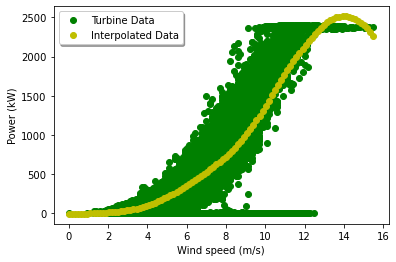

In [62]:
#plot results
fig, ax = plt.subplots()
ax.plot(x, y, 'go', label='Turbine Data')
ax.plot(xP, yP, 'yo', label='Interpolated Data')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
plt.show()

In [64]:
#save itnerpolated data to a df
di = pd.DataFrame({'Windspeed': xP,'Power': yP})

#positive values for power
di=di[(di.Power >= 0.0)]

di

,Windspeed,Power
9,1.409091,1.088154
10,1.565657,3.288506
11,1.722222,5.724707
12,1.878788,8.396757
13,2.035354,11.304656
...,...,...
95,14.873737,2430.905940
96,15.030303,2397.801062
97,15.186869,2359.246067
98,15.343434,2315.240957


### Met Eirean Data

In [65]:
#meteirean data
cnx = sqlite3.connect('MetEirean.db')

#Find the name of the table
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

met_eireann_api
met_eireann_com


In [70]:
me_full = pd.read_sql_query("SELECT * FROM met_eireann_com", cnx)
me=me_full[["period", "u100wind","v100wind"]]
me.head(5)
%store me

Stored 'me' (DataFrame)


In [24]:
me['windspeed'] = np.sqrt(me['u100wind'].pow(2) + me['v100wind'].pow(2))
#values greater than 1 for windspeed
me=me[(me.windspeed > 1.5) & (me.windspeed <15.5)]
me=me.sort_values(by=['windspeed'])
me.head(5)

<ipython-input-24-12cbc8de6091>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  me['windspeed'] = np.sqrt(me['u100wind'].pow(2) + me['v100wind'].pow(2))


,period,u100wind,v100wind,windspeed
61769,2021-05-28 12:00:00,0.536,-1.403,1.50190
62201,2021-05-28 12:00:00,0.536,-1.403,1.50190
61337,2021-05-28 12:00:00,0.536,-1.403,1.50190
62369,2021-05-29 12:00:00,1.472,-0.300,1.50226
62801,2021-05-29 12:00:00,1.472,-0.300,1.50226


## Interpolation

In [69]:
w, p = di['Windspeed'].values, di['Power'].values

# Interpolate (w,p)
f = si.interp1d(w, p, kind='cubic')

# Apply interpolation curve to windspeed values in forecast to get power.
me['power'] = me['windspeed'].apply(f).round(3)
me

KeyError: 'windspeed'

## Check Data

In [45]:
df1 = me.loc[(me['windspeed'] > 2.8) & (me['windspeed'] < 3) , ['windspeed','power']]
df1=df1.rename(columns={'power':'Power_ME'})
df2 = df_hourly.loc[(df_hourly["wind"] > 2.8) & (df_hourly["wind"] < 3) , ['wind','power']]
df2=df2.rename(columns={'power':'Power_Turbine'})

#result = df1.append(df2, ignore_index=True, sort=False)
#result = pd.concat([df1, df2], axis=1)
print( "\033[1m"+"MetEirean Dataframe"+"\033[0m")
print(df1.head(10))
print("\n")
print( "\033[1m"+"Interpolated Data"+"\033[0m")
print(df2.head(10))


MetEirean Dataframe
       windspeed  Power_ME
60636   2.801951    29.741
61068   2.801951    29.741
61500   2.801951    29.741
8088    2.802697    29.766
8466    2.802697    29.766
8736    2.802697    29.766
59167   2.803088    29.780
59599   2.803088    29.780
58735   2.803088    29.780
28527   2.804524    29.828


Interpolated Data
        wind  Power_Turbine
112337   2.9           24.0
32756    2.9           17.0
33160    2.9           17.0
106887   2.9           30.0
106885   2.9           30.0
23693    2.9           32.0
30308    2.9           32.0
12088    2.9            6.0
24683    2.9           23.0
11364    2.9            9.0
